### Exploratory analysis of the post study questionnaire responses

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

np.random.seed(42)
sns.set_style('ticks')
sns.set_palette('colorblind')

likert_order = [
    'strongly disagree', 
    'disagree', 
    'neutral', 
    'agree', 
    'strongly agree'
]

In [2]:
post_study = pd.read_csv('../data/post-study.csv')
post_study.head()

,user_id,user_created,part,choice_satisfaction_one,choice_satisfaction_two,choice_satisfaction_three,choice_satisfaction_four,choice_satisfaction_five,choice_satisfaction_six,choice_satisfaction_seven,...,intention,relevant_one,relevant_two,relevant_three,relevant_four,trust_one,trust_two,trust_three,trust_four,trust_five
0,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_one,agree,neutral,neutral,agree,neutral,neutral,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
1,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_two,neutral,disagree,neutral,disagree,neutral,disagree,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
2,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_one,neutral,neutral,neutral,agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
3,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_two,neutral,neutral,neutral,strongly agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
4,27405dfe-adee-47e8-b002-818e61c5c552,2022-07-22 14:36:52.999452,part_one,agree,agree,strongly agree,strongly agree,agree,neutral,disagree,...,agree,disagree,disagree,disagree,disagree,strongly disagree,agree,agree,disagree,strongly agree


In [3]:
# literally no idea what happened here
post_study = post_study.rename(columns = {'choice_satisfaction_three.1': 'perceived_effectiveness_three'})
post_study.columns

Index(['user_id', 'user_created', 'part', 'choice_satisfaction_one',
       'choice_satisfaction_two', 'choice_satisfaction_three',
       'choice_satisfaction_four', 'choice_satisfaction_five',
       'choice_satisfaction_six', 'choice_satisfaction_seven',
       'choice_satisfaction_eight', 'choice_satisfaction_nine',
       'perceived_effectiveness_one', 'perceived_effectiveness_two',
       'perceived_effectiveness_three', 'perceived_effectiveness_four',
       'perceived_effectiveness_five', 'perceived_effectiveness_six',
       'perceived_effectiveness_seven', 'perceived_effectiveness_eight',
       'perceived_effectiveness_nine', 'perceived_effectiveness_ten',
       'perceived_quality_one', 'perceived_quality_two',
       'perceived_quality_three', 'perceived_quality_four',
       'perceived_quality_five', 'perceived_quality_six', 'test_awareness_one',
       'test_awareness_two', 'intention', 'relevant_one', 'relevant_two',
       'relevant_three', 'relevant_four', 'trust_one'

In [4]:
questions = {
    q: [x for x in post_study.columns if q in x]
    for q in ['satisfaction', 'effectiveness', 'quality', 'awareness', 'intention', 'relevant', 'trust']
}

In [5]:
# add in the users model condition and order - important for understanding
# the data.
post_study = post_study.merge(
    pd.read_csv(
        '../data/users.csv', usecols = ['user_id', 'condition', 'order']
    ),
    on = 'user_id'
)

In [6]:
post_study[['user_id', 'part', 'condition', 'order']].head(10)

,user_id,part,condition,order
0,62b14681-8d4a-44b5-a201-942bba9b4bd8,part_one,image,model
1,62b14681-8d4a-44b5-a201-942bba9b4bd8,part_two,image,model
2,09cf0e31-cf99-47f3-906f-8da336f23f73,part_one,meta,model
3,09cf0e31-cf99-47f3-906f-8da336f23f73,part_two,meta,model
4,27405dfe-adee-47e8-b002-818e61c5c552,part_one,image,model
5,27405dfe-adee-47e8-b002-818e61c5c552,part_two,image,model
6,c2252483-1049-4965-b569-b02ad21fdfe3,part_one,concatenated,model
7,c2252483-1049-4965-b569-b02ad21fdfe3,part_two,concatenated,model
8,eff7dbbd-c503-45b5-b9ea-d6591880a3d0,part_one,concatenated,model
9,eff7dbbd-c503-45b5-b9ea-d6591880a3d0,part_two,concatenated,model


In [7]:
# create a column where the part and order are concatenated, e.g.
# part_one_model (with part_two_random), so the plots are more informative
part_one_data = post_study[post_study.part == 'part_one'][['user_id', 'part', 'order']]
part_two_data = post_study[post_study.part == 'part_two'][['user_id', 'part', 'order']]

part_one_data['part_order'] = part_one_data['part'] + '_' + part_one_data['order']

def _concat_part_two_order(row, col = 'order'):
    order = part_one_data[part_one_data['user_id'] == row['user_id']][col].item()
    
    if col == 'order':
        if order == 'model':
            return 'part_two_random'
        return 'part_two_model'
    else:
        return 'part_two_' + order

part_two_data['part_order'] = part_two_data.apply(_concat_part_two_order, axis = 1)

part_one_data = part_one_data.append(part_two_data, ignore_index = True)

post_study = post_study.merge(
    right = part_one_data[['user_id', 'part', 'part_order']],
    on = ['user_id', 'part'],
    how = 'left'
)
# post_study[['user_id', 'part', 'order', 'part_order']].head(10)


<ipython-input-7-c75f5e823e49>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  part_one_data = part_one_data.append(part_two_data, ignore_index = True)


In [8]:
# Do the same as above but with the condition - again, useful for plotting
post_study['part_condition'] = post_study['part'] + '_' + post_study['condition']

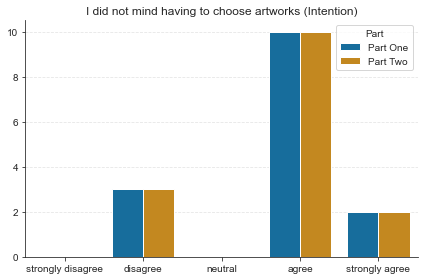

In [9]:
# Plot the intention results split by the part (one and two)
p = sns.countplot(
    x = 'intention', hue = 'part',
    data = post_study, 
    order = likert_order
)
p.set(
    title = 'I did not mind having to choose artworks (Intention)',
    xlabel = '',
    ylabel = ''
)
p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
plt.legend(
    title = 'Part',
    labels = ['Part One', 'Part Two']
)

sns.despine()
plt.tight_layout()
plt.show()

In [10]:
post_study[['user_id', 'part', 'condition', 'order', 'part_order']].head()

,user_id,part,condition,order,part_order
0,62b14681-8d4a-44b5-a201-942bba9b4bd8,part_one,image,model,part_one_model
1,62b14681-8d4a-44b5-a201-942bba9b4bd8,part_two,image,model,part_two_random
2,09cf0e31-cf99-47f3-906f-8da336f23f73,part_one,meta,model,part_one_model
3,09cf0e31-cf99-47f3-906f-8da336f23f73,part_two,meta,model,part_two_random
4,27405dfe-adee-47e8-b002-818e61c5c552,part_one,image,model,part_one_model


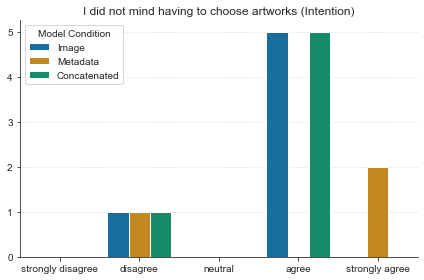

In [11]:
# Create the same plot as a above but split by the condition
p = sns.countplot(
    x = 'intention', hue = 'condition', 
    data = post_study[post_study.part_order.str.contains('model')],
    order = likert_order
)

p.set(
    title = 'I did not mind having to choose artworks (Intention)',
    xlabel = '',
    ylabel = ''
)
p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
plt.legend(
    title = 'Model Condition',
    labels = ['Image', 'Metadata', 'Concatenated'],
    loc = 'upper left'
)

sns.despine()
plt.tight_layout()
plt.show()

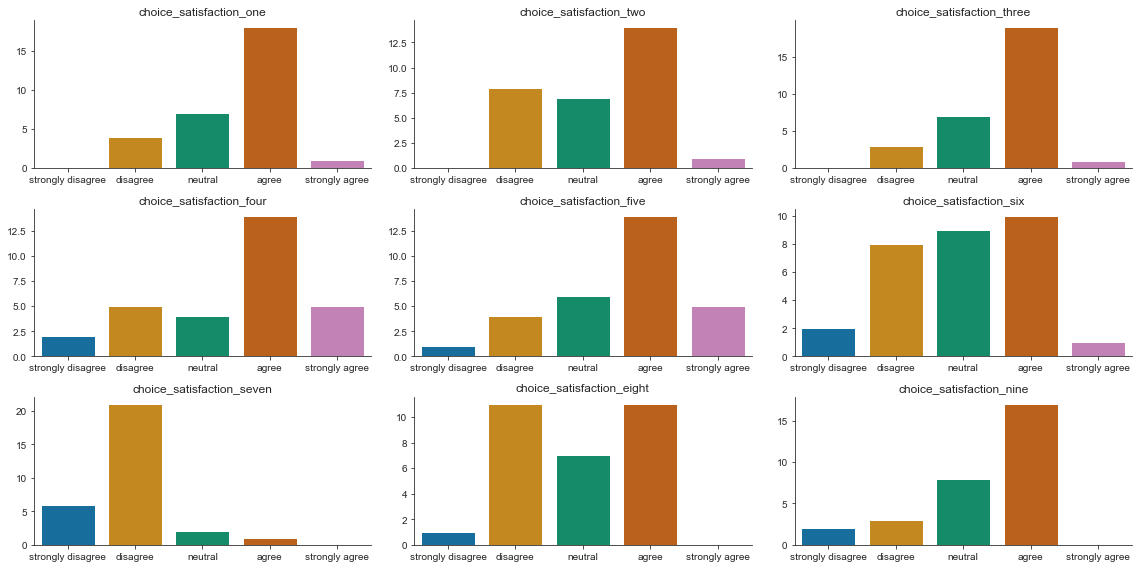

In [17]:
# Create a larger multi-plot for the bigger question groupings, i.e., satisfaction (5x2)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_order
    )
    p.set(
        ylabel = '',
        xlabel = '',
        title = q
    )

sns.despine()
plt.tight_layout()

<ipython-input-20-63f30cf85f38>:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(


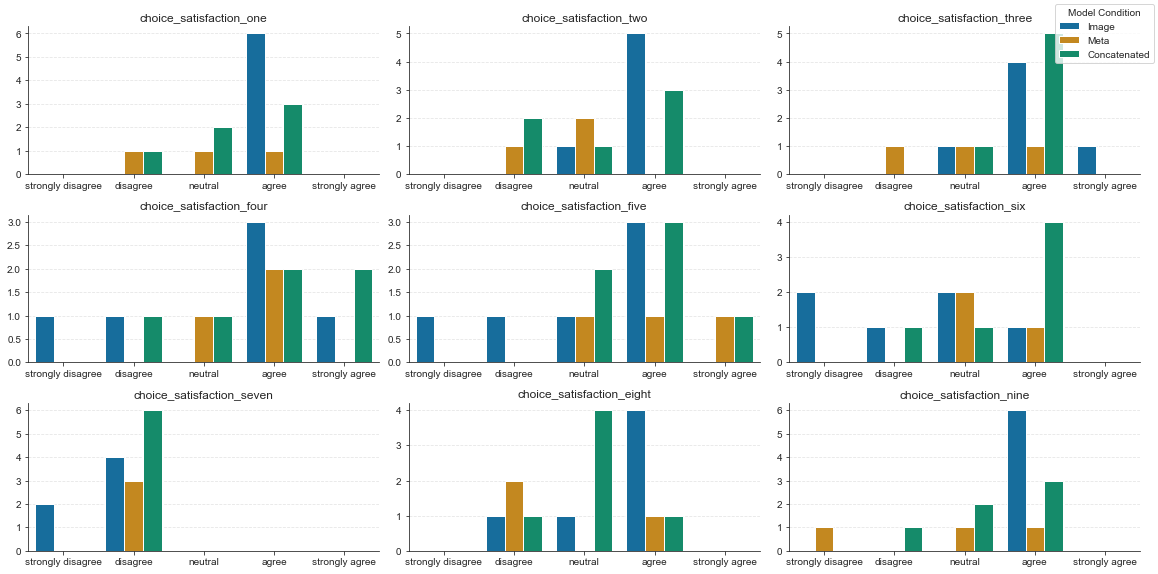

In [20]:
# Same plot as above but with the hue set based on the condition
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

plots = []
for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, 
        hue = 'condition',
        data = post_study[post_study.part_order.str.contains('model')], 
        ax = ax, 
        order = likert_order
    )
    p.set(
        ylabel = '',
        xlabel = '',
        title = q
    )
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')
    p.legend_.remove()
    plots.append(p)

fig.legend(
    plots, 
    labels = ['Image', 'Meta', 'Concatenated'],
    title = 'Model Condition'
)
# plt.legend(
#     title = 'Model Condition',
#     labels = ['Image', 'Metadata', 'Concatenated'],
#     loc = 'upper left'
# )


sns.despine()
plt.tight_layout()